In [16]:
%matplotlib inline
import os
import sys
from itertools import combinations
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats.mstats import gmean
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

### Size Factor Rescaling

Size factors are calculated to render counts from different samples, which may have been sequenced to different depths, comparable. 

j...m = Samples <br>
i...n = Genes <br>
k = counts

One size factor is calculated per sample

$$\hat{s}_j = \mbox{median_i} \frac{k_{ij}}{\Big( \Pi^m_{v=1}k_{iv} \Big)^{1/m}}$$

We can then produce what the DESeq2 authors call "variance stabalized normalized counts" by computing:
$\mbox{log2}\big(\frac{\mbox{count}}{\mbox{size_factor}}\big)$ for all counts in the matrix

In [7]:
def size_factor_scale(df):
    # Calculate denominator
    # The geometric mean for all genes across all samples
    # We'll pad the counts with a +1 so the geometric mean is never 0
    df = df.apply(lambda x: x + 1)
    denom = gmean(df, axis=1)  # Length n
    temp = df.divide(denom, axis=0)
    size_factors = temp.median(axis=0)
    return df.divide(size_factors, axis=1).apply(lambda x: np.log2(x))

In [8]:
def quantile_normalize(df):
    """
    Quantile normalization is a technique for making two distributions identical in statistical properties.
    Assuming genes by samples
    from: http://stackoverflow.com/questions/37935920/quantile-normalization-on-pandas-dataframe
    """
    rank_mean = df.stack().groupby(df.rank(method='first').stack().astype(int)).mean()
    return df.rank(method='min').stack().astype(int).map(rank_mean).unstack()

In [14]:
def run_pca(df):
    pca = PCA(n_components=2)
    return pca.fit(df).transform(df)

def run_tsne(df):
    model = TSNE(n_components=2, random_state=1)
    return model.fit_transform(np.array(df))

In [10]:
def get_label(df):
    labels = []
    for sample in df.columns:
        if 'GTEX-' in sample:
            labels.append(0)
        elif sample.endswith('01'):
            labels.append(1)
        elif sample.endswith('11'):
            labels.append(2)
        else:
            labels.append(3)
    return np.array(labels)

In [11]:
def plot_dimensionality_reduction(x, label, title, alpha=0.5):
    f, ax = plt.subplots()
    names = ['GTEX', 'TCGA-T', 'TCGA-N', 'TCGA-O']
    cm = plt.get_cmap('Accent')
    color_set = (cm(1. * i / len(names)) for i in xrange(len(names)))
    length = [0, 1, 2, 3] #[z for z in xrange(len(names))]
    for color, i, target_name in zip(color_set, length, names):
        ax.scatter(x[label == i, 0], x[label == i, 1], alpha=alpha, color=color, label=target_name)
    ax.legend(loc='best', fontsize=6)
    ax.set_title(title)
    
    # Cluster distance measurements
    tcga_tn_dist = None
    tcga_gtex_dist = None
    for a, b in combinations(set(label), 2):
        dist = np.sqrt((x[label == a, 0].mean() - x[label == b, 0].mean()) ** 2 +
                       (x[label == a, 1].mean() - x[label == b, 1].mean()) ** 2)
        print 'Distance for: {:>8} {:>8} {:>8}'.format(names[a], names[b], dist)
        if sum([a,b]) == 2:  # GTEX / TCGA-N
            tcga_gtex_dist = dist
        elif sum([a,b]) == 3:  # TCGA-T / TCGA-N
            tcga_tn_dist = dist
    if tcga_gtex_dist < tcga_tn_dist:
        print 'GTEx and TCGA Normal are more similar!'
    else:
        print 'TCGA tumor / normal are more similar'

### Test

In [12]:
df = pd.read_csv('/mnt/rna-seq-analysis/data/tissue-pairs/prostate/combined-gtex-tcga-counts-protein-coding.tsv', sep='\t', index_col=0)
label = get_label(df)
df = df.T  # Definitely didn't waste 2 hours before figuring out my matrices needed to be transposed.

### PCA

Plotting the raw expression data

Distance for:     GTEX   TCGA-T 604157.618293
Distance for:     GTEX   TCGA-N 1226000.35792
Distance for:     GTEX   TCGA-O 299395.448159
Distance for:   TCGA-T   TCGA-N 1255724.37959
Distance for:   TCGA-T   TCGA-O 330590.376499
Distance for:   TCGA-N   TCGA-O 1292000.11213
GTEx and TCGA Normal are more similar!


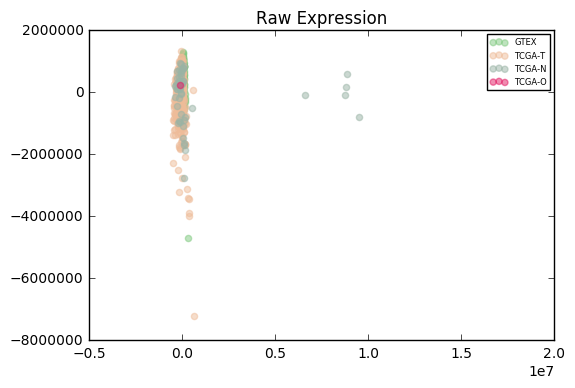

In [38]:
y = run_pca(df)
plot_dimensionality_reduction(y, label, 'Raw Expression')

Looks like trash.

Let's look into some preprocessing. I was initially using log(x + 1) where x is the count value.

Distance for:     GTEX   TCGA-T 113.365441487
Distance for:     GTEX   TCGA-N 106.780793129
Distance for:     GTEX   TCGA-O 176.13681755
Distance for:   TCGA-T   TCGA-N 60.3095954055
Distance for:   TCGA-T   TCGA-O 69.2511195099
Distance for:   TCGA-N   TCGA-O 83.7873955336
TCGA tumor / normal are more similar


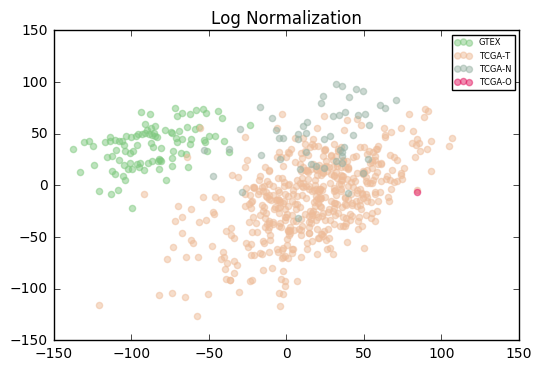

In [39]:
t = df.apply(lambda x: np.log(x + 1))
y = run_pca(t)
plot_dimensionality_reduction(y, label, 'Log Normalization')

That's looking a bit better. The normal tissue and gtex tissue cluster more closely than the tumor tissue which is what we'd expect to see.

Now we'll try quantile normalization

Distance for:     GTEX   TCGA-T 189992.190763
Distance for:     GTEX   TCGA-N 193470.878329
Distance for:     GTEX   TCGA-O 616428.174665
Distance for:   TCGA-T   TCGA-N 118121.938374
Distance for:   TCGA-T   TCGA-O 450945.338542
Distance for:   TCGA-N   TCGA-O 428222.798673
TCGA tumor / normal are more similar


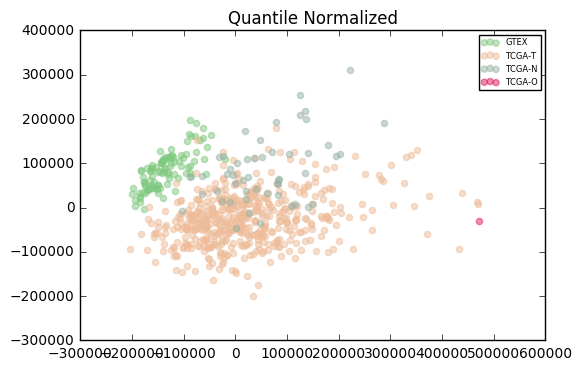

In [40]:
t = quantile_normalize(df)
y = run_pca(t)
plot_dimensionality_reduction(y, label, 'Quantile Normalized')

Worse separation than log scaling.

Distance for:     GTEX   TCGA-T 163.551760242
Distance for:     GTEX   TCGA-N 154.052120709
Distance for:     GTEX   TCGA-O 254.111713197
Distance for:   TCGA-T   TCGA-N 87.0083542095
Distance for:   TCGA-T   TCGA-O 99.908246693
Distance for:   TCGA-N   TCGA-O 120.879660025
TCGA tumor / normal are more similar


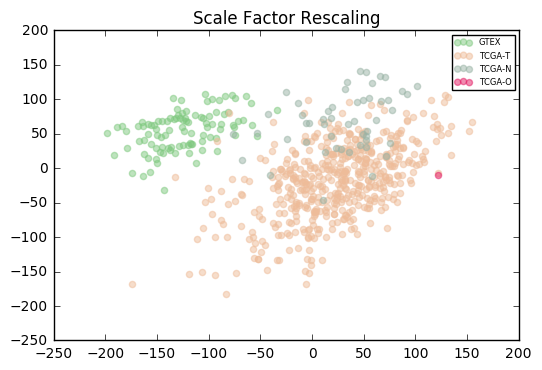

In [41]:
t = size_factor_scale(df)
y = run_pca(t)
plot_dimensionality_reduction(y, label, 'Scale Factor Rescaling')

Distance for:     GTEX   TCGA-T 147.509692482
Distance for:     GTEX   TCGA-N 147.721130645
Distance for:     GTEX   TCGA-O 283.326735057
Distance for:   TCGA-T   TCGA-N 67.9879687967
Distance for:   TCGA-T   TCGA-O 154.830453006
Distance for:   TCGA-N   TCGA-O 137.110966742
TCGA tumor / normal are more similar


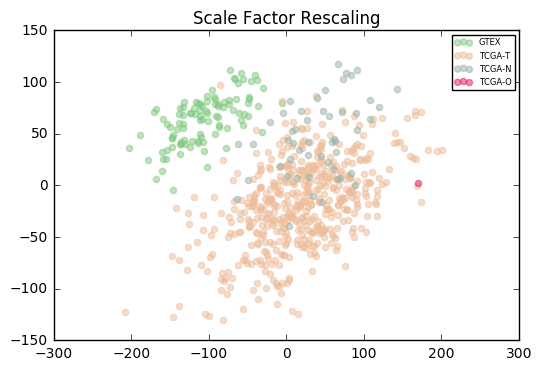

In [42]:
t = size_factor_scale(df)
t = quantile_normalize(t)
y = run_pca(t)
plot_dimensionality_reduction(y, label, 'Scale Factor Rescaling')

### T-SNE

Distance for:     GTEX   TCGA-T 31.7940005929
Distance for:     GTEX   TCGA-N 22.6892535136
Distance for:     GTEX   TCGA-O 48.468038665
Distance for:   TCGA-T   TCGA-N 9.13306737968
Distance for:   TCGA-T   TCGA-O 17.6310228083
Distance for:   TCGA-N   TCGA-O 26.0803883558
TCGA tumor / normal are more similar


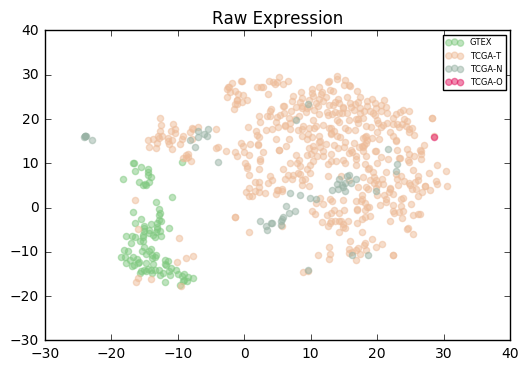

In [43]:
y = run_tsne(df)
plot_dimensionality_reduction(y, label, 'Raw Expression')

Distance for:     GTEX   TCGA-T 27.7515260327
Distance for:     GTEX   TCGA-N 26.8496249258
Distance for:     GTEX   TCGA-O 41.0953514516
Distance for:   TCGA-T   TCGA-N 12.334777879
Distance for:   TCGA-T   TCGA-O 14.5067217192
Distance for:   TCGA-N   TCGA-O 24.8575456681
TCGA tumor / normal are more similar


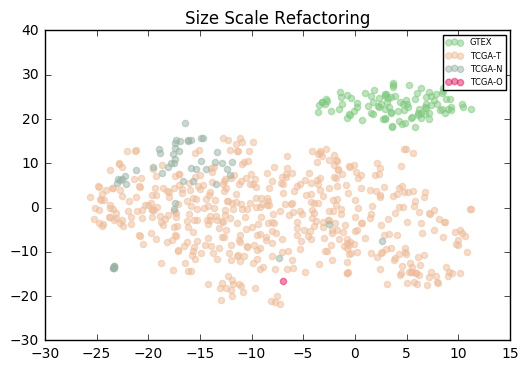

In [44]:
t = size_factor_scale(df)
y = run_tsne(t)
plot_dimensionality_reduction(y, label, 'Size Scale Refactoring')

Distance for:     GTEX   TCGA-T 54.5051864552
Distance for:     GTEX   TCGA-N 51.3021398947
Distance for:     GTEX   TCGA-O 41.091559564
Distance for:   TCGA-T   TCGA-N 10.6609905348
Distance for:   TCGA-T   TCGA-O 21.0846385472
Distance for:   TCGA-N   TCGA-O 12.3862673067
TCGA tumor / normal are more similar


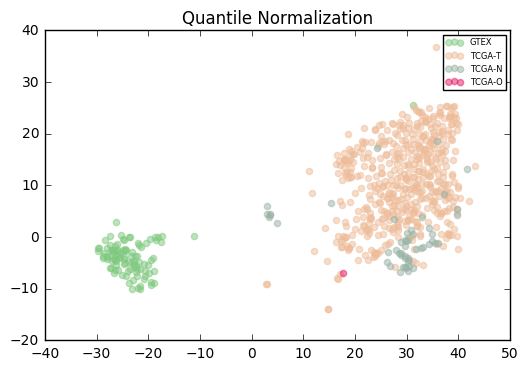

In [45]:
t = quantile_normalize(df)
y = run_tsne(t)
plot_dimensionality_reduction(y, label, 'Quantile Normalization')

Distance for:     GTEX   TCGA-T 37.290498587
Distance for:     GTEX   TCGA-N 47.508955018
Distance for:     GTEX   TCGA-O 39.7461231452
Distance for:   TCGA-T   TCGA-N 12.4507276271
Distance for:   TCGA-T   TCGA-O 21.0954895566
Distance for:   TCGA-N   TCGA-O 18.2327132402
TCGA tumor / normal are more similar


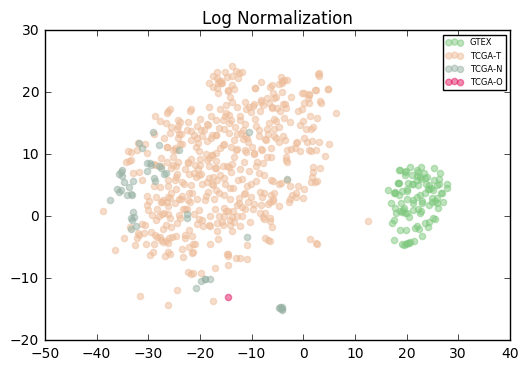

In [17]:
t = df.apply(lambda y: np.log(y + 1))
y = run_tsne(t)
plot_dimensionality_reduction(y, label, 'Log Normalization')